In [1]:
import xarray as xr
import pandas as pd
import seaborn as sns

%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('jan2017/jan18_morning.csv',sep=';')
df.pm10 = df.pm10.astype(float)

In [3]:
def clean(df, sensor_id=1):
    df.timestamp = pd.to_datetime(df.timestamp)
    
        
    df = df.sort_values(by='timestamp')
    
    time = (df.timestamp > '2017-01-15') & (df.timestamp < '2017-01-22')
    df = df[time & (df.id == sensor_id)]
    #df = df.set_index('timestamp', 'id')
    
    return df


In [4]:
df = clean(df)

In [5]:
# load kings

df_kings_vol = pd.read_csv('my1_volume_18jan.csv')
df_kings_vol['timestamp'] = pd.to_datetime(df_kings_vol.date)

def filter_by_time(df):
    time = (df.timestamp >= '2017-01-17 13:00') & (df.timestamp <= '2017-01-18 12:00')
    return df[time]

# co is in ppm
df_kings_vol.co = 1000 * df_kings_vol.co

df_kings_vol = filter_by_time(df_kings_vol)
df_kings_vol = df_kings_vol.set_index('timestamp')
ds_kings_vol = xr.Dataset.from_dataframe(df_kings_vol)
kings_prefix = dict([(v, 'kings_'+v) for v in ds_kings_vol.data_vars])

def compare(ds_merged, airpublic_measure, kings_measure):
    ds_merged_one = ds_merged[[airpublic_measure, kings_measure]]
    # ds_merged_one['error'] = ds_merged_one[kings_measure] - ds_merged[airpublic_measure]
    #ds_merged_one.sel(datetime=example_date).to_dataframe().plot()
    ds_merged_one.to_dataframe().plot()
    sns.pairplot(ds_merged_one.to_dataframe().dropna().reset_index(), vars=ds_merged_one.data_vars)
    print ds_merged_one.to_dataframe().describe()

# correct co formula

In [8]:
ANALOG_REF_VOLTAGE = 3.3;

# sensor 1 values from mcu ( they are wrong and differ from datasheet)

mcu_CO_WORKING_ELECTRODE_ZERO_OFFSET_MV  = 310;
mcu_CO_AUXILIARY_ELECTRODE_ZERO_OFFSET_MV  = 272;
mcu_CO_SENSITIVITY  = 0.197; # it is wrong on the mcu(switched with no2)

# reverse to raw readings
def reverse_co(CO_working=None, CO_aux=None, ppbCO=None):
    
    # float voltageCO_working = ANALOG_REF_VOLTAGE * raw_CO_working / 1024.0 * 1000.0;
    # sensor_readings->mvCO_working = voltageCO_working;
    
    raw_CO_working_1 = CO_working * 1024.0 / (1000.0 *ANALOG_REF_VOLTAGE)
    
    raw_CO_working_2 = (ppbCO * mcu_CO_SENSITIVITY + mcu_CO_WORKING_ELECTRODE_ZERO_OFFSET_MV) * 1024.0 / (1000.0 * ANALOG_REF_VOLTAGE)
 
    assert abs(raw_CO_working_1 - raw_CO_working_2) < 0.05
    
  # float voltageCO_aux = ANALOG_REF_VOLTAGE * raw_CO_aux / 1024.0 * 1000.0;
  #  sensor_readings->mvCO_aux = voltageCO_aux; 
    
    raw_CO_aux = CO_aux * 1024.0 / (1000.0 * ANALOG_REF_VOLTAGE)    
  
    return raw_CO_working_1, raw_CO_aux

ANALOG_REF_VOLTAGE = 3.3;
    
# sensor #1 from datasheet( not from MCU)
CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  = 268;
CO_WORKING_ELECTRODE_SENSOR_ZERO_MV  = 42;

CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV  = 262;
CO_AUXILIARY_ELECTRODE_SENSOR_ZERO_MV  = 10;
CO_SENSITIVITY = 0.228; # mv/ppb

def correct_co(CO_working=None, CO_aux=None, ppbCO=None, temp_correction = +1):
    # temp corretion is +1 up to 20 deg Cels, then -1, then -0.7 after 30C
    
    # reverse engineering CO conversion done on MCU     
    raw_CO_working, raw_CO_aux = reverse_co(CO_working=CO_working, CO_aux=CO_aux, ppbCO=ppbCO)
    
    scaled_aux =  raw_CO_aux - CO_AUXILIARY_ELECTRODE_SENSOR_ZERO_MV * temp_correction - CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV
    
    scaled_working = raw_CO_working - CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  - CO_WORKING_ELECTRODE_SENSOR_ZERO_MV

    return  (scaled_working -  scaled_aux )/CO_SENSITIVITY

In [12]:
df['raw_CO_working'] = df[['co_working','co_aux','co']].apply(lambda x: reverse_co(x.values[0], x.values[1], x.values[2])[0], axis=1)
df['raw_CO_aux'] = df[['co_working','co_aux','co']].apply(lambda x: reverse_co(x.values[0], x.values[1], x.values[2])[1], axis=1)

In [10]:
df['co_correct_formula'] = df[['co_working','co_aux','co']].apply(lambda x: correct_co(x.values[0], x.values[1], x.values[2]), axis=1)

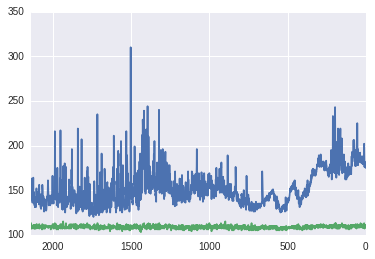

In [18]:
df.raw_CO_working.plot()
df.raw_CO_aux.plot()

In [45]:
df.co_correct_formula.describe()

count    2077.000000
mean       23.571417
std        82.212210
min      -118.488038
25%       -39.415205
50%         4.408293
75%        70.279638
max       706.128655
Name: co_correct_formula, dtype: float64

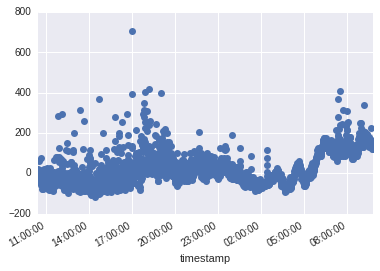

In [46]:

ds = xr.Dataset.from_dataframe(df.set_index('timestamp', 'id'))
ds_mean_1h = ds.resample(freq='1H', dim='timestamp', how='mean', skipna=True)
df.set_index('timestamp').co_correct_formula.plot(linestyle='none', marker='o')
#ds = ds.set_coords(['timestamp','id'])
#ds = ds.set_coords(['timestamp','id'])

In [47]:

#ds_mean_24h = ds.resample(freq='24H', dim='timestamp', how='mean', skipna=True)


         kings_co  co_correct_formula
count   19.000000           20.000000
mean   492.543860           24.000907
std    221.803333           59.295664
min    200.000000          -52.135116
25%    345.833333          -21.069975
50%    450.000000           17.351366
75%    537.500000           57.667147
max    950.000000          141.001313


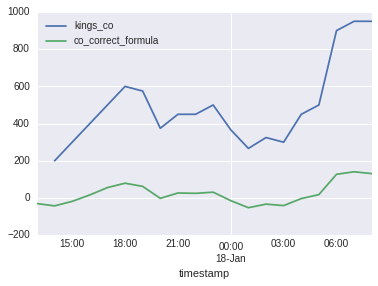

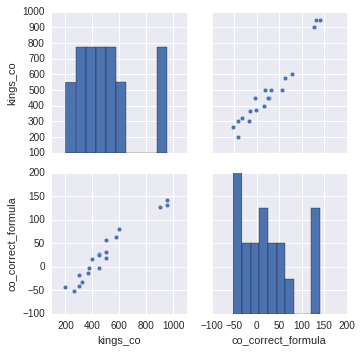

In [48]:
ds_merged = xr.merge([ds_kings_vol.rename(kings_prefix), ds_mean_1h]
                     , join='inner')
compare(ds_merged,'kings_co','co_correct_formula')

## Correct NO


In [20]:
ANALOG_REF_VOLTAGE = 3.3;

# sensor 1 values from mcu ( they are wrong and differ from datasheet)


mcu_NO2_WORKING_ELECTRODE_ZERO_OFFSET_MV  = 297;
mcu_NO2_AUXILIARY_ELECTRODE_ZERO_OFFSET_MV = 295;
mcu_NO2_SENSITIVITY = 0.228;


# reverse to raw readings
def reverse_NO2(NO2_working=None, NO2_aux=None, ppbNO2=None): 
       
#  float voltageNO2_working = ANALOG_REF_VOLTAGE * raw_NO2_working / 1024.0 * 1000.0;
#     //logMessage(VERBOSE, "Voltage NO2 Working Electrode (mV): " + String(voltageNO2_working));
#     sensor_readings->mvNO2_working = voltageNO2_working;
   
    raw_NO2_working_1 = NO2_working * 1024.0 / (1000.0 *ANALOG_REF_VOLTAGE)
    
#         float voltageNO2_working_corrected = voltageNO2_working - NO2_WORKING_ELECTRODE_ZERO_OFFSET_MV;
#     //logMessage(VERBOSE, "Corrected Voltage NO2 Working Electrode (mV): " + String(voltageNO2_working_corrected));
    
#     float ppbNO2 = voltageNO2_working_corrected / NO2_SENSITIVITY;
#     logMessage(INFO, "NO2:" + String(ppbNO2));
#     sensor_readings->ppbNO2 = ppbNO2;

    raw_NO2_working_2 = (ppbNO2 * mcu_NO2_SENSITIVITY + mcu_NO2_WORKING_ELECTRODE_ZERO_OFFSET_MV) * 1024.0 / (1000.0 * ANALOG_REF_VOLTAGE)
 
    assert abs(raw_NO2_working_1 - raw_NO2_working_2) < 0.05
    
#     float voltageNO2_aux = ANALOG_REF_VOLTAGE * raw_NO2_aux / 1024.0 * 1000.0;
#     //logMessage(VERBOSE, "Voltage NO2 Auxiliary Electrode (mV): " + String(voltageNO2_aux));
#     sensor_readings->mvNO2_aux = voltageNO2_aux;
      
    raw_NO2_aux = NO2_aux * 1024.0 / (1000.0 * ANALOG_REF_VOLTAGE)    
  
    return raw_NO2_working_1, raw_NO2_aux

   
# sensor #1 from datasheet( not from MCU)
NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  = 295;
NO2_WORKING_ELECTRODE_SENSOR_ZERO_MV  = 2;
NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV  = 295;
NO2_AUXILIARY_ELECTRODE_SENSOR_ZERO_MV  = 0;
NO2_SENSITIVITY = 0.197; # mv/ppb

def correct_no2(NO2_working=None, NO2_aux=None, ppbNO2=None, temp_correction = +1.09):
    # temp corretion is +1.09 up to 20 deg Cels, then 1.35, then 3 after 30C
    
    # reverse engineering CO conversion done on MCU     
    raw_NO2_working, raw_NO2_aux = reverse_NO2(NO2_working=NO2_working, NO2_aux=NO2_aux, ppbNO2=ppbNO2)
    
    scaled_aux =  raw_NO2_aux - NO2_AUXILIARY_ELECTRODE_SENSOR_ZERO_MV * temp_correction - NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV
    
    scaled_working = raw_NO2_working - NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  - NO2_WORKING_ELECTRODE_SENSOR_ZERO_MV

    return  (scaled_working -  scaled_aux )/NO2_SENSITIVITY

In [21]:
df['raw_NO2_working'] = df[['no2_working','no2_aux','no2']].apply(lambda x: reverse_NO2(x.values[0], x.values[1], x.values[2])[0], axis=1)
df['raw_NO2_aux'] = df[['no2_working','no2_aux','no2']].apply(lambda x: reverse_NO2(x.values[0], x.values[1], x.values[2])[1], axis=1)

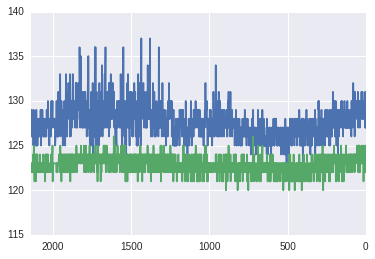

In [25]:
df['raw_NO2_working'].plot()
df['raw_NO2_aux'].plot()

In [50]:
df['no2_correct_formula'] = df[['no2_working','no2_aux','no2']].apply(lambda x: correct_no2(x.values[0], x.values[1], x.values[2]), axis=1)
df.no2_correct_formula.describe()

count    2077.000000
mean       14.118406
std         8.133101
min       -10.152284
25%        10.167051
50%        15.207507
75%        20.247962
max        65.927088
Name: no2_correct_formula, dtype: float64

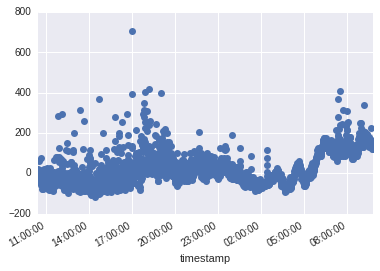

In [51]:

ds = xr.Dataset.from_dataframe(df.set_index('timestamp', 'id'))
ds_mean_1h = ds.resample(freq='1H', dim='timestamp', how='mean', skipna=True)
df.set_index('timestamp').co_correct_formula.plot(linestyle='none', marker='o')

       kings_no2  no2_correct_formula
count  19.000000            20.000000
mean   52.392931            13.955239
std     9.749879             3.465699
min    36.768175             7.587972
25%    45.259812            11.178508
50%    51.498600            14.150453
75%    58.665725            16.673265
max    73.067325            19.323878


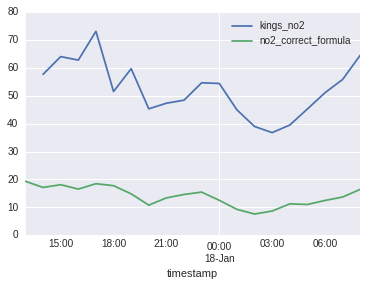

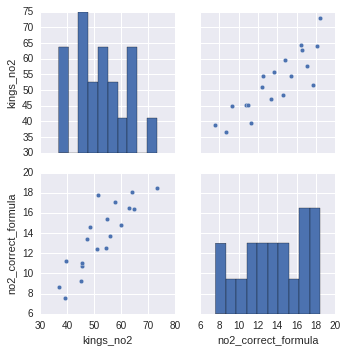

In [59]:

ds_merged = xr.merge([ds_kings_vol.rename(kings_prefix), ds_mean_1h]
                     , join='inner')
compare(ds_merged,'kings_no2','no2_correct_formula')

In [56]:
# Pm10

       kings_pm10        pm10
count   20.000000   20.000000
mean    58.368885   47.252279
std     11.370683   47.401765
min     43.119607   16.836222
25%     51.234482   22.076440
50%     55.703788   33.176817
75%     62.594729   38.825096
max     88.085102  215.159352


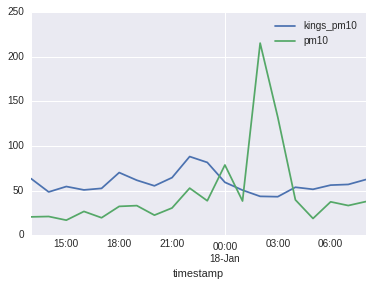

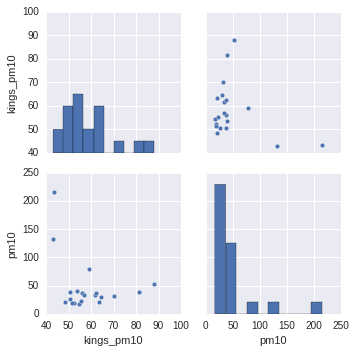

In [57]:
compare(ds_merged, 'kings_pm10', 'pm10')